In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
#Fetching from yFinance
def fetch_stock_data(ticker, start="2024-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start)
    df.reset_index(inplace=True)
    #Returning DataFrame    
    
    return df

In [3]:
def preprocess_data(df):
    #Splitting the date into 3 parts
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    
    #Adding their Sin and Cosine Factors for their seasonal factors    
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    
    #The Stock has Dependent Variables of the Date in our Model
    features = [ 'Year', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
    X = df[features]
    
    #For predicting we'll use Closing Value as Independent Variable
    #type = High, Low, Close
    y_high = df['High']
    y_low = df['Low']
    y_close = df['Close']

    return X, y_high, y_low, y_close

In [4]:
def train_and_evaluate_model(X, y):
    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Model Fitting
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    #Predicting
    y_pred = model.predict(X_test_scaled)
    
    #Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    #Printing Metrics
    print(f"Model Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    
    #Returning Model
    return model, scaler

In [5]:
def predict_future_prices(model, scaler, last_date, choice, n_days=20):
    #The Future Date is to be processed to fit in Dependent Variables
    future_dates = pd.date_range(start=last_date, periods=n_days + 1)[1:]
    future_df = pd.DataFrame({
        'Year': future_dates.year,
        'Month_sin': np.sin(2 * np.pi * future_dates.month / 12),
        'Month_cos': np.cos(2 * np.pi * future_dates.month / 12),
        'Day_sin': np.sin(2 * np.pi * future_dates.day / 31),
        'Day_cos': np.cos(2 * np.pi * future_dates.day / 31)
    })
    
    future_scaled = scaler.transform(future_df)
    future_predictions = model.predict(future_scaled)
    
    prediction_df = pd.DataFrame({'Date': future_dates, f'Predicted_{choice}': future_predictions})
    
    return prediction_df

In [26]:
#Requesting Ticker and Number of Days
# ticker = input("Enter stock ticker: ").upper()
# n_days = int(input("Enter number of days to predict: "))
ticker = "TSLA"
n_days = 180
#Calling Functions
df = fetch_stock_data(ticker)
X, y_high, y_low, y_close = preprocess_data(df)

#High
print("\nHigh")
model, scaler = train_and_evaluate_model(X, y_high)
future_high = predict_future_prices(model, scaler, df['Date'].iloc[-1], "High", n_days)

#Low
print("\nLow")
model, scaler = train_and_evaluate_model(X, y_low)
future_low = predict_future_prices(model, scaler, df['Date'].iloc[-1], "Low", n_days)


#Close
print("\nClose")
model, scaler = train_and_evaluate_model(X, y_close)
future_close = predict_future_prices(model, scaler, df['Date'].iloc[-1], "Close", n_days)


High
Model Performance:
R² Score: 0.6453
Mean Absolute Error (MAE): 35.3439
Mean Squared Error (MSE): 1969.2639
Root Mean Squared Error (RMSE): 44.3764
Mean Absolute Percentage Error (MAPE): 0.1472

Low
Model Performance:
R² Score: 0.4977
Mean Absolute Error (MAE): 44.5033
Mean Squared Error (MSE): 3333.5938
Root Mean Squared Error (RMSE): 57.7373
Mean Absolute Percentage Error (MAPE): 0.1701

Close
Model Performance:
R² Score: 0.6735
Mean Absolute Error (MAE): 36.6672
Mean Squared Error (MSE): 2088.5330
Root Mean Squared Error (RMSE): 45.7005
Mean Absolute Percentage Error (MAPE): 0.1533


In [27]:
df.describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Day,Month_sin,Month_cos,Day_sin,Day_cos
count,313.000000,313.000000,313.000000,313.000000,3.130000e+02,313.0,313.0,313.000000,313.000000,313.000000,313.000000,3.130000e+02,3.130000e+02,313.000000
mean,250.730959,256.252524,244.636230,250.412875,9.538575e+07,0.0,0.0,2024.194888,5.654952,15.731629,0.147676,8.058285e-02,9.629074e-03,-0.023181
std,81.233112,83.365179,78.243295,80.793062,3.341290e+07,0.0,0.0,0.396749,3.584482,8.771212,0.717622,6.781089e-01,7.186163e-01,0.697254
min,140.559998,144.440002,138.800003,142.050003,3.716760e+07,0.0,0.0,2024.000000,1.000000,1.000000,-1.000000,-1.000000e+00,-9.987165e-01,-0.994869
25%,185.300003,188.800003,182.100006,185.100006,7.115980e+07,0.0,0.0,2024.000000,2.000000,8.000000,-0.500000,-5.000000e-01,-7.247928e-01,-0.758758
50%,224.880005,230.100006,218.929993,223.270004,8.775220e+07,0.0,0.0,2024.000000,5.000000,16.000000,0.500000,6.123234e-17,-2.449294e-16,-0.050649
75%,282.660004,289.589996,271.820007,281.950012,1.115352e+08,0.0,0.0,2024.000000,9.000000,23.000000,0.866025,8.660254e-01,7.247928e-01,0.688967
max,475.899994,488.540009,457.510010,479.859985,2.438697e+08,0.0,0.0,2025.000000,12.000000,31.000000,1.000000,1.000000e+00,9.987165e-01,1.000000


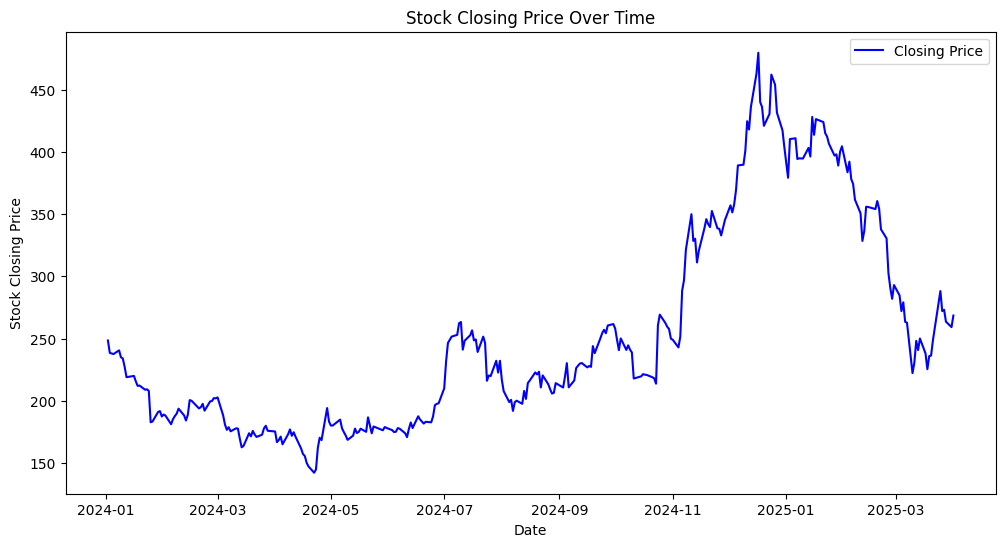

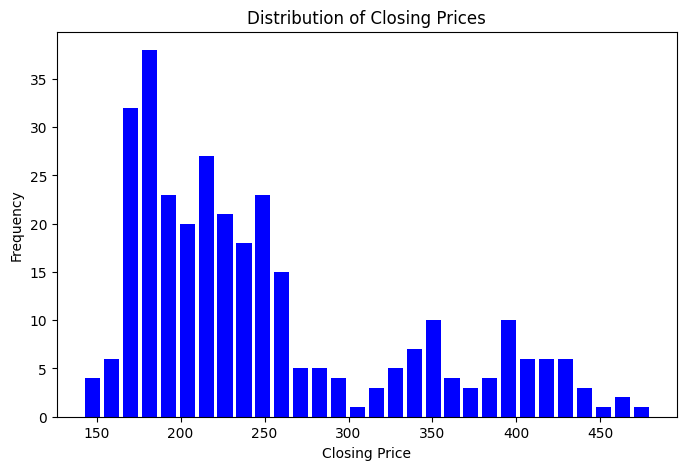

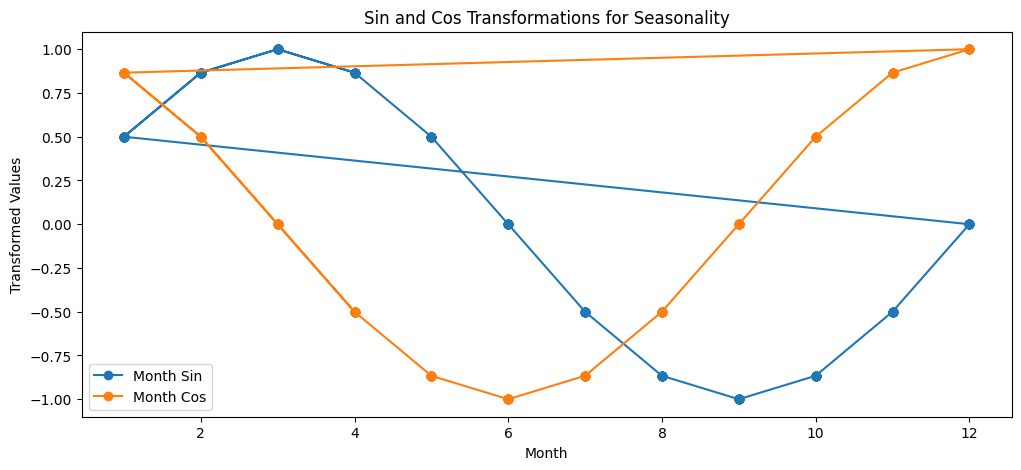

In [28]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Closing Price", color='b')
plt.xlabel("Date")
plt.ylabel("Stock Closing Price")
plt.title("Stock Closing Price Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['Close'], bins=30, color='blue', rwidth= 0.8)
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df['Month'], df['Month_sin'], label='Month Sin', marker='o')
plt.plot(df['Month'], df['Month_cos'], label='Month Cos', marker='o')
plt.xlabel("Month")
plt.ylabel("Transformed Values")
plt.title("Sin and Cos Transformations for Seasonality")
plt.legend()
plt.show()



In [29]:
last_actual_high = pd.DataFrame({
    'Date': [df['Date'].iloc[-1]],
    'Predicted_High': [df['High'].iloc[-1]]
})

connected_high = pd.concat([last_actual_high, future_high], ignore_index=True)

last_actual_low = pd.DataFrame({
    'Date': [df['Date'].iloc[-1]],
    'Predicted_Low': [df['Low'].iloc[-1]]
})

connected_low = pd.concat([last_actual_low, future_low], ignore_index=True)

last_actual_close = pd.DataFrame({
    'Date': [df['Date'].iloc[-1]],
    'Predicted_Close': [df['Close'].iloc[-1]]
})

connected_close = pd.concat([last_actual_close, future_close], ignore_index=True)


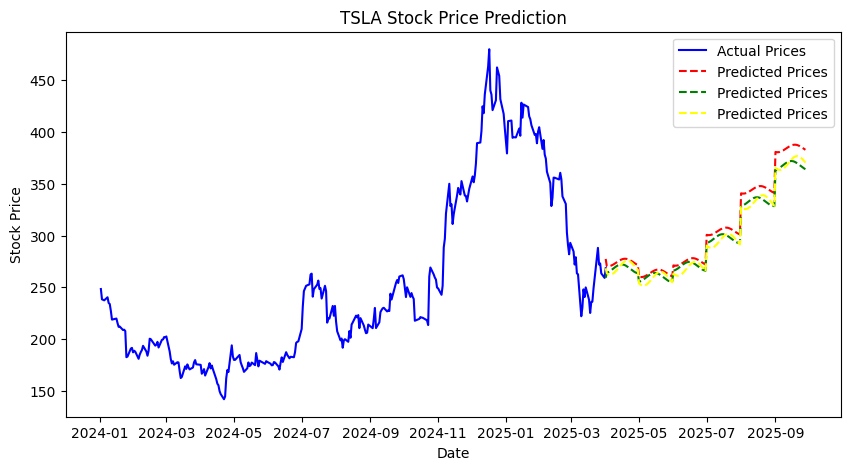

In [30]:
#Plotting Prediction
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label="Actual Prices", color='blue')
plt.plot(connected_high['Date'], connected_high['Predicted_High'], label="Predicted Prices", color='red', linestyle="dashed")
plt.plot(connected_low['Date'], connected_low['Predicted_Low'], label="Predicted Prices", color='green', linestyle="dashed")
plt.plot(connected_close['Date'], connected_close['Predicted_Close'], label="Predicted Prices", color='yellow', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.show()